### Ideas 

#### replicate /use the discriminative loss func for instance segmentation

- [Semantic Instance Segmentation with a Discriminative Loss Function](https://arxiv.org/abs/1708.02551)
- useful github repo here https://github.com/Wizaron/instance-segmentation-pytorch

#### deep watershed transform 
- https://spark-in.me/post/playing-with-dwt-and-ds-bowl-2018
- 

### Imports and setup

In [3]:
from fastai.imports import *
from fastai.vision import *
import tifffile as tiff
from skimage.external import tifffile as sktif
from skimage.measure import *
from skimage.morphology import *
from joblib import Parallel, delayed
import torch.functional as F

from torch.nn.modules.loss import _Loss
from torch.autograd import Variable
from torch.utils.data import Dataset
import torch

from skimage.segmentation import *
from scipy.ndimage.morphology import distance_transform_edt as SDT
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.io import imread_collection
import functools, traceback
def gpu_mem_restore(func):
    "Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"

%matplotlib inline

In [4]:
data_dir = Path("/media/wwymak/Storage/urban-3D-satellite")
train_dir = data_dir / "training"
cropped_dir =  data_dir / "cropped_training"
cropped_val_dir =  data_dir / "cropped_validation"

In [6]:
def get_img_id(fname):
    fname = fname.replace('_RGB.tif', '')
    img_id = "_".join(fname.split('_')[:-1])
    return img_id

train_img_ids = [get_img_id(f.name) for f in cropped_dir.ls() if f.name.endswith('RGB.tif')]
val_img_ids = [get_img_id(f.name) for f in cropped_val_dir.ls() if f.name.endswith('RGB.tif')]

In [7]:
train_cropped_imgs = [f.name for f in (data_dir / "cropped_training").ls() if f.name.endswith('RGB.tif')]
valid_cropped_imgs = [f.name for f in (data_dir / "cropped_validation").ls() if f.name.endswith('RGB.tif')]

train_cropped_gti_masks = [data_dir / "cropped_training"/ f.replace('RGB', 'GTI') for f in train_cropped_imgs]
valid_cropped_gti_masks = [data_dir / "cropped_validation"/ f.replace('RGB', 'GTI') for f in valid_cropped_imgs]

In [8]:
def accuracy_pixel(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

def flatten_binary_scores2(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.contiguous().view(-1)
    labels = labels.contiguous().view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels
def lovasz_hinge(logits, labels, per_image=False, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    print(logits.min(), logits.max(), logits.size())
    logits=logits[:,1,:,:]
    labels = labels.squeeze(1)
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores2(logits, labels, ignore))
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(torch.nn.functional.relu(errors_sorted), Variable(grad))
    return loss

def combined_loss2(logits, labels):
    logits=logits[:,1,:,:].float()
    labels = labels.squeeze(1).float()
    
    lh_loss = lovasz_hinge_flat(*flatten_binary_scores2(logits, labels))
    bce_loss = F.binary_cross_entropy_with_logits(logits, labels)
    
    return 0.8 * bce_loss + lh_loss

In [9]:
train_cropped_imgs = [f.name for f in (data_dir / "cropped_training").ls() if f.name.endswith('RGB.tif')]
valid_cropped_imgs = [f.name for f in (data_dir / "cropped_validation").ls() if f.name.endswith('RGB.tif')]

dataset_df = pd.DataFrame({"name":[f"cropped_training/{f}" for f in train_cropped_imgs]  \
   + [f"cropped_validation/{f}" for f in valid_cropped_imgs],
   "label": [f"{str(data_dir)}/cropped_training/{f.replace('RGB', 'pytorch_GTL')}" for f in train_cropped_imgs]  \
   + [f"{str(data_dir)}/cropped_validation/{f.replace('RGB', 'pytorch_GTL')}" for f in valid_cropped_imgs],\
        "is_valid":   [False for i in train_cropped_imgs] + [True for i in valid_cropped_imgs ]   })

#### Baby first step-- can we predict teh signed distance transform directly?

In [61]:
def create_sdt_mask(mask_fname, outpath):
    img = sktif.imread(str(mask_fname))
    sdt = SDT(img, sampling=0.5)
    sdt = 255 * sdt/sdt.max()
    sktif.imsave(str(outpath),sdt.astype('float32'))

In [62]:
inpaths = train_cropped_gti_masks
outpaths = [str(f).replace("GTI", "SDT") for f in inpaths]
%time  out=[create_sdt_mask(inpath, outpath) for inpath, outpath in zip(inpaths, outpaths)];

/home/wwymak/anaconda3/envs/solaris/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


CPU times: user 6.58 s, sys: 364 ms, total: 6.95 s
Wall time: 7.34 s


In [63]:
inpaths_val = valid_cropped_gti_masks
outpaths_val = [str(f).replace("GTI", "SDT") for f in inpaths_val]
%time out= [create_sdt_mask(inpath, outpath) for inpath, outpath in zip(inpaths_val, outpaths_val)];

/home/wwymak/anaconda3/envs/solaris/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


CPU times: user 1.46 s, sys: 72 ms, total: 1.53 s
Wall time: 1.64 s


In [64]:
dataset_df["SDT_label"] = dataset_df.label.str.replace("pytorch_GTL", "SDT")
dataset_df.head()

,name,label,is_valid,SDT_label
0,cropped_training/JAX_Tile_091_1_RGB.tif,/media/wwymak/Storage/urban-3D-satellite/cropp...,False,/media/wwymak/Storage/urban-3D-satellite/cropp...
1,cropped_training/TAM_Tile_030_4_RGB.tif,/media/wwymak/Storage/urban-3D-satellite/cropp...,False,/media/wwymak/Storage/urban-3D-satellite/cropp...
2,cropped_training/JAX_Tile_121_10_RGB.tif,/media/wwymak/Storage/urban-3D-satellite/cropp...,False,/media/wwymak/Storage/urban-3D-satellite/cropp...
3,cropped_training/TAM_Tile_070_4_RGB.tif,/media/wwymak/Storage/urban-3D-satellite/cropp...,False,/media/wwymak/Storage/urban-3D-satellite/cropp...
4,cropped_training/JAX_Tile_067_7_RGB.tif,/media/wwymak/Storage/urban-3D-satellite/cropp...,False,/media/wwymak/Storage/urban-3D-satellite/cropp...


In [65]:
src = (ImageImageList.from_df(dataset_df, path=data_dir )
      . split_from_df(col="is_valid")
       .label_from_df(cols="SDT_label"))

In [66]:
size = 128
bs=32
data = (src.transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

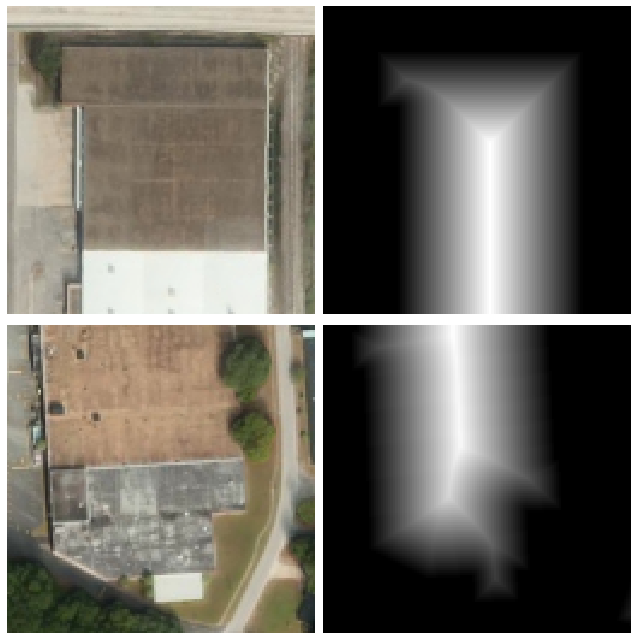

In [67]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

In [31]:
# PIL.Image.open('/media/wwymak/Storage/urban-3D-satellite/cropped_training/JAX_Tile_091_1_SDT.tif', mode='L')
a.shape


(256, 256)

Taking inspiration from the DWT-- create mask with 7 layers:
- boundary
- mask - boundary
- mask thinned 
- mask more thinned
- signed distance transform vectors?

In [10]:
collection = imread_collection(train_cropped_gti_masks[:10])
signed_distance_transforms = SDT(collection[0], sampling=0.5)

In [12]:
collection.shape

AttributeError: 'ImageCollection' object has no attribute 'shape'

In [22]:
codes = ["background", "building"]
src = (SegmentationItemList.from_df(dataset_df, path=data_dir )
      . split_from_df(col="is_valid")
       .label_from_df(cols="label", classes=codes))

In [24]:
wd =1e-2
metrics = [accuracy_pixel,dice]

size = 256
bs=32
data = (src.transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))


learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, loss_func=combined_loss2)
learn.to_fp16();

In [25]:
learn.load('lovaz-loss-stage4-ignore-none');

In [35]:
predicted = learn.pred_batch(DatasetType.Valid)

In [36]:
combined = predicted.argmax(dim=1)
combined.size()

torch.Size([32, 256, 256])

Text(0.5, 1.0, 'Real mask')

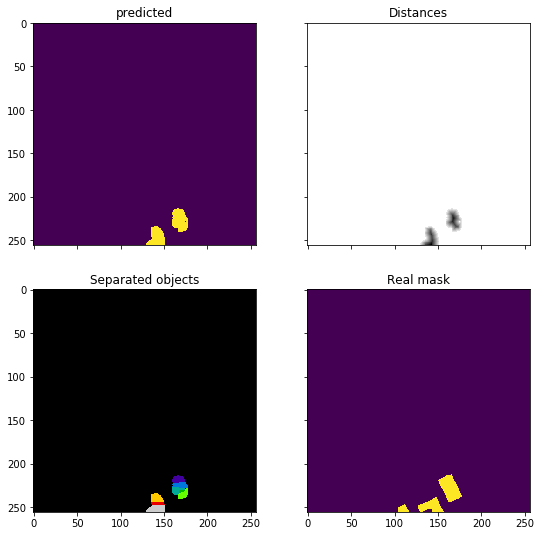

In [48]:
predicted_mask = combined[19].numpy()
real_mask = sktif.imread(data.valid_ds.y.items[19])
distance = ndi.distance_transform_edt(predicted_mask)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=predicted_mask)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=predicted_mask)

fig, axes = plt.subplots(ncols=2,nrows=2, figsize=(9, 9), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(predicted_mask)
ax[0].set_title('predicted')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')
ax[3].imshow(real_mask)
ax[3].set_title('Real mask')


In [40]:
data.valid_ds.y.items

array(['/media/wwymak/Storage/urban-3D-satellite/cropped_validation/TAM_Tile_058_11_pytorch_GTL.tif',
       '/media/wwymak/Storage/urban-3D-satellite/cropped_validation/JAX_Tile_071_10_pytorch_GTL.tif',
       '/media/wwymak/Storage/urban-3D-satellite/cropped_validation/JAX_Tile_103_3_pytorch_GTL.tif',
       '/media/wwymak/Storage/urban-3D-satellite/cropped_validation/TAM_Tile_100_5_pytorch_GTL.tif', ...,
       '/media/wwymak/Storage/urban-3D-satellite/cropped_validation/JAX_Tile_108_11_pytorch_GTL.tif',
       '/media/wwymak/Storage/urban-3D-satellite/cropped_validation/JAX_Tile_103_12_pytorch_GTL.tif',
       '/media/wwymak/Storage/urban-3D-satellite/cropped_validation/TAM_Tile_119_7_pytorch_GTL.tif',
       '/media/wwymak/Storage/urban-3D-satellite/cropped_validation/TAM_Tile_045_6_pytorch_GTL.tif'], dtype=object)

### Trying out skimage cv methods to see how they work:

#### finding boundaries

In [13]:
test_img = sktif.imread(str(train_cropped_gti_masks[0]))
boundary_test = find_boundaries(test_img, how="outer")

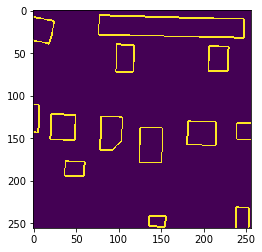

In [8]:
plt.imshow(boundary_test)

#### signed distance transform

In [32]:
distance_Tranform_test = SDT(test_img, sampling=0.5)
distance_Tranform_test.shape

(256, 256)

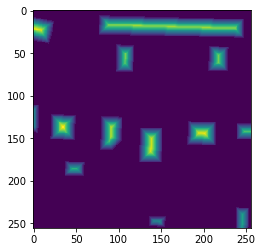

In [10]:
plt.imshow(distance_Tranform_test)

In [46]:
distance_Tranform_test.max(), distance_Tranform_test.min()

(7.0, 0.0)

In [50]:
np.argwhere(distance_Tranform_test_normed >= 1/3)[0, :]

array([10, 82])

In [18]:
img_properties = regionprops(test_img)
img_properties

In [35]:
peaks = [prop.centroid for prop in img_properties]
markers2 = np.zeros((test_img.shape))
for idx, (peak_r, peak_c) in enumerate(peaks):
    markers2[int(peak_r): int(peak_c)] = idx 

In [36]:
local_maxi = peak_local_max(distance_Tranform_test, indices=False, footprint=np.ones((3, 3)),
                            labels=test_img)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance_Tranform_test, markers2, mask=test_img)

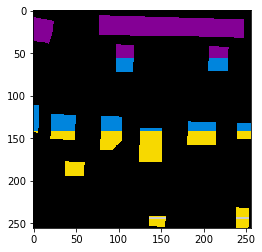

In [37]:
plt.imshow(labels, cmap=plt.cm.nipy_spectral)

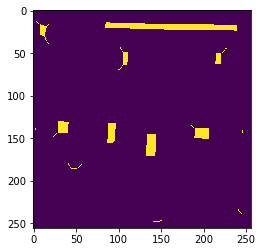

In [45]:
#### mask thinning
iterations = 8
min_x, max_x = np.argwhere(test_img > 0)[:,0].min(),np.argwhere(test_img > 0)[:,0].max()
min_y, max_y = np.argwhere(test_img > 0)[:,1].min(),np.argwhere(test_img > 0)[:,1].max()

empty = np.zeros_like(test_img)
try:
    empty[min_x:max_x,min_y:max_y] = thin(test_img[min_x:max_x,min_y:max_y],max_iter=iterations)

except:
    pass

plt.imshow(empty)dataset_df.head()

In [ ]:
#### Predicti

### Custom dataset

In [49]:
def create_boundary_mask(filepath):
    instance_mask = sktif.imread(filepath)
    boundary = find_boundaries(instance_mask, mode="outer")
    fname = filepath.replace('_GTI', 'boundary')
    sktif.imsave(fname)

In [20]:
dataset_df.head()

,name,label,is_valid
0,cropped_training/JAX_Tile_091_1_RGB.tif,/media/wwymak/Storage/urban-3D-satellite/cropp...,False
1,cropped_training/TAM_Tile_030_4_RGB.tif,/media/wwymak/Storage/urban-3D-satellite/cropp...,False
2,cropped_training/JAX_Tile_121_10_RGB.tif,/media/wwymak/Storage/urban-3D-satellite/cropp...,False
3,cropped_training/TAM_Tile_070_4_RGB.tif,/media/wwymak/Storage/urban-3D-satellite/cropp...,False
4,cropped_training/JAX_Tile_067_7_RGB.tif,/media/wwymak/Storage/urban-3D-satellite/cropp...,False


In [13]:
a = imread_collection(fnames[:10])

In [7]:
def embedding_mean(prediction, taget):
    """
    target shape=batch_size x w x 
    """
    n_instances = target.size(2)
    pass

def variance_term(prediction, target):
    pass

def distance_term():
    pass

def regularisation_term():
    pass

def discriminative_loss():
    pass

torch.Size([3, 2])

In [15]:
masks = a.concatenate()

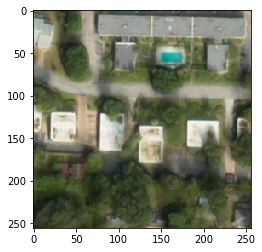

In [19]:
plt.imshow(masks[0])

In [ ]:
. split_from_df(col="is_valid")